## in this version the histogram is taken around the meighborhood for each point in the catalog

In [1]:
import fitsio, time, sys
import numpy as np
from mpmath import *
from concurrent.futures import ProcessPoolExecutor as Executor
sys.path.append("/home/joar/google-drive/PhD/NPCF/pyMethodsClasses/")
from QTrees import Point, Rect, QuadTree
from histoStuffs import *
from scipy.special import eval_legendre as Pl

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import ImageGrid

cmap=plt.get_cmap('RdBu')

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

norm = MidpointNormalize(midpoint=0)

In [6]:
file_name = '~/google-drive/PhD/NPCF/codes_npcf/treeCorr/convergence/data/Aardvark_cpy.fit'
data = fitsio.read(file_name)

In [7]:
dataConv=[]
for ii,jj,kk in zip(data["RA"],data["DEC"],data["KAPPA"]):
    dataConv.append(Point(ii,jj,payload=kk))

In [8]:
# for rectangle's domain 
minRA,maxRA=min(data["RA"]),max(data["RA"])
minDEC,maxDEC=min(data["DEC"]),max(data["DEC"])
domWidth=maxRA-minRA
domHeight=maxDEC-minDEC
cx=(maxRA+minRA)/2
cy=(maxDEC+minDEC)/2
# rectangle's domain
domain = Rect(cx, cy, domWidth, domHeight)
qtree = QuadTree(domain)
for point in dataConv:
    qtree.insert(point)

In [9]:
# parms to run 3pcf
nrbin=30 #bins r
nmubin=30 #bins mu
nthtbin=nmubin
nskip=1 #step in pts
patchWidth=domWidth/6
patchHeight=domHeight/4
rmin= 1.
rmax= domHeight*np.sqrt(2)/4
rArr=np.arange(rmin,rmax,(rmax-rmin)/nrbin)
muArr=np.arange(-1,1,2./nmubin)
Nchunks=10 #threads per job

In [7]:
print(rmax)

3.981718651707619


In [12]:
# we need to loop over each pnt in catalog
patchesPnts=[]
kkk_patches=[]
for pnt in dataConv[:60:15]:
    t1=time.perf_counter()
    #patch=Rect(pnt.x,pnt.y,patchWidth,patchHeight)
    #fndPts=[];
    fndPtsR=[]
    #qtree.query(patch,fndPts)
    qtree.query_radius((pnt.x,pnt.y),rmax,fndPtsR)
    print("found pts:", len(fndPtsR))
    #fnd_Pts=[[p.x,p.y,p.payload] for p in fndPts]
    fnd_PtsR=[[p.x,p.y,p.payload] for p in fndPtsR]
    #patchesPnts.append([[p.x,p.y,p.payload] for p in fndPts])
    patchesPnts.append(fndPtsR)
    jobs=[]
    #params=get_params(Nchunks,fnd_Pts)
    #print(*get_params(Nchunks,fnd_Pts))
    paramsR=get_params(Nchunks,fnd_PtsR)
    print(*get_params(Nchunks,fnd_PtsR))
    for ii in paramsR:
        jobs.append(Executor(max_workers=2).submit(KKK,ii[0],ii[1],nskip,fnd_PtsR,\
                       rmin,rmax,nrbin,nmubin,'mu'))
    results=[]
    for ii in jobs:
        results.append(ii.result())
    hist=np.zeros((nrbin,nrbin,nthtbin))
    for ii in results:
        hist+=np.array(ii)
    kkk_patches.append(hist)
    t2=time.perf_counter()
    print("time:%7.2f"%(t2-t1))

found pts: 508
[0, 50] [50, 101] [101, 152] [152, 203] [203, 254] [254, 304] [304, 355] [355, 406] [406, 457] [457, 508]
time: 856.36
found pts: 745
[0, 74] [74, 149] [149, 223] [223, 298] [298, 372] [372, 447] [447, 521] [521, 596] [596, 670] [670, 745]
time:2701.51
found pts: 748
[0, 74] [74, 149] [149, 224] [224, 299] [299, 374] [374, 448] [448, 523] [523, 598] [598, 673] [673, 748]
time:2724.51
found pts: 497
[0, 49] [49, 99] [99, 149] [149, 198] [198, 248] [248, 298] [298, 347] [347, 397] [397, 447] [447, 497]
time: 808.75


In [10]:
#np.save("/home/joar/temporal/NPCF_data/BruteForce/szapudiPlane_v2_rrmu_n3_circles",kkk_patches)
kkk_patches=np.load("/home/joar/temporal/NPCF_data/BruteForce/szapudiPlane_v2_rrmu_n3_circles.npy")

In [9]:
DPI = 72
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()
ax.set_xlim(minRA, maxRA)
ax.set_ylim(minDEC, maxDEC)
qtree.draw(ax)
ax.scatter([p.x for p in dataConv], [p.y for p in dataConv], s=4)
#ax.set_xticks([])
#ax.set_yticks([])
fc=["red","orange","green","magenta",\
    "red","orange","green","magenta",\
    "red","orange","green","magenta",\
    "red","orange","green","magenta"]
for ii,nn in enumerate(patchesPnts):
    
    ax.scatter([p.x for p in nn],[p.y for p in nn],facecolors='none',\
               edgecolors=fc[-ii], s=32,alpha=.4)
    #ax.scatter([p.x for p in patchesPnts[1]],[p.y for p in patchesPnts[1]],facecolors='none',\
    #           edgecolors=fc[2], s=32,alpha=.4)
    #ax.scatter([p.x for p in patchesPnts[2]],[p.y for p in patchesPnts[2]],facecolors='none',\
    #           edgecolors=fc[0], s=32,alpha=.4)
#for ii,nn in enumerate(fndPts):
#    ax.scatter([p.x for p in nn],[p.y for p in nn],facecolors='none',\
#               edgecolors=fc[ii], s=32)
#    regions[ii].draw(ax, c=fc[ii])

#ax.invert_yaxis()
plt.tight_layout()
#plt.savefig('search-quadtree.png', DPI=72)
plt.show()

NameError: name 'patchesPnts' is not defined

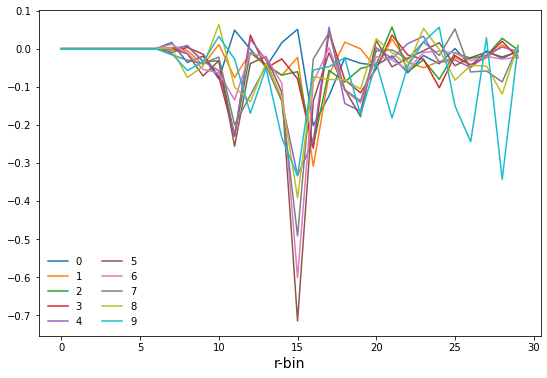

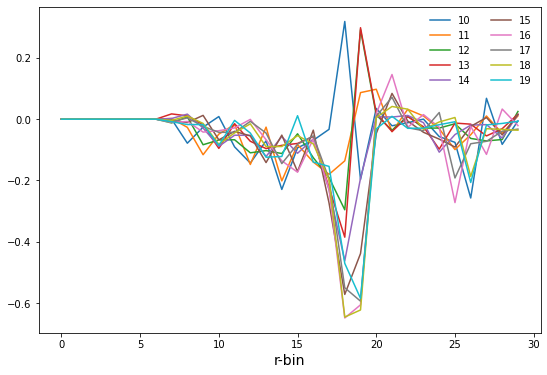

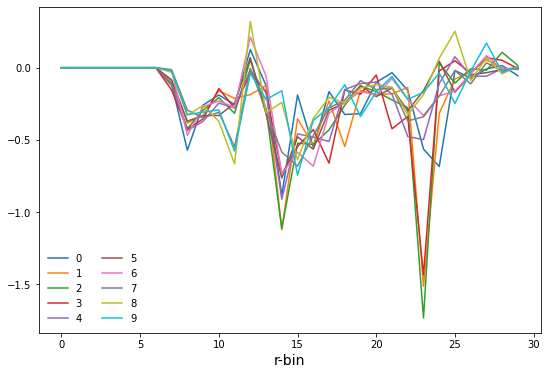

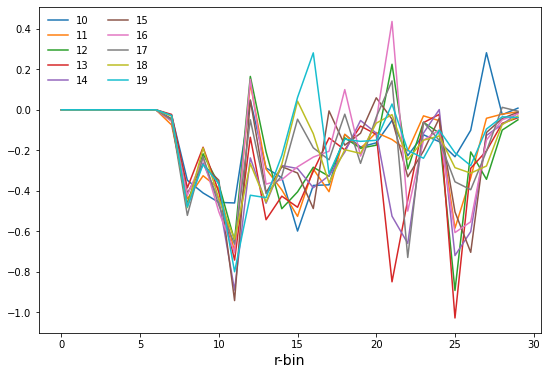

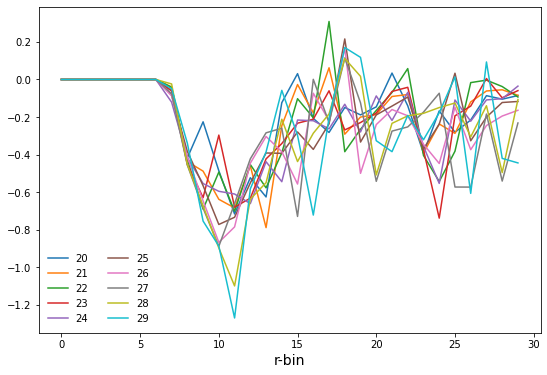

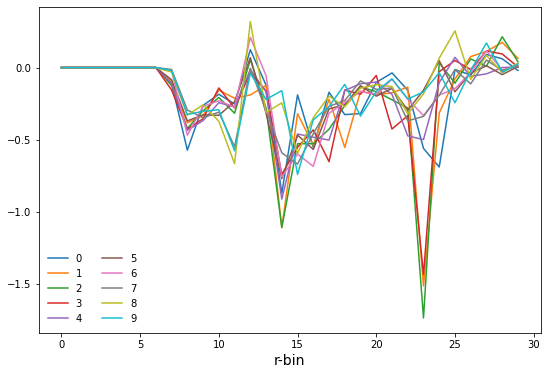

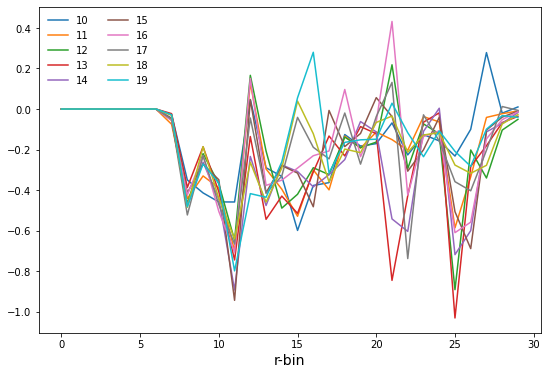

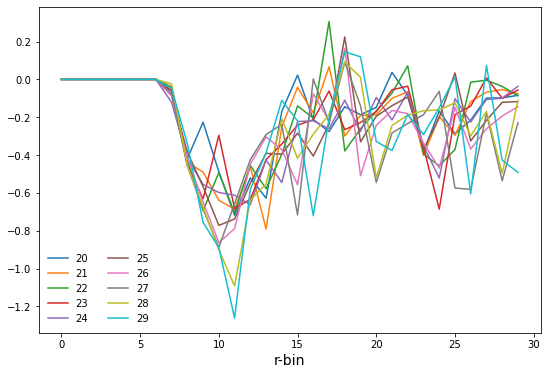

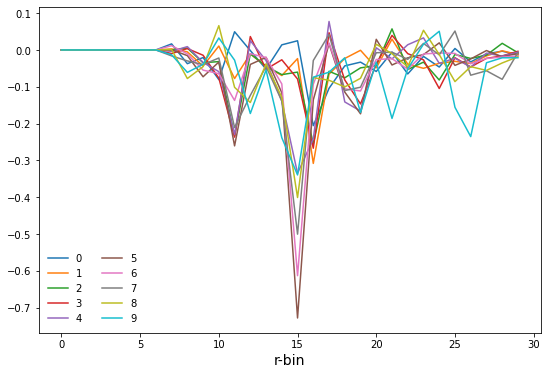

In [10]:
for nn in range(len(kkk_patches)):   
    plt.figure(figsize=(9,6))
    for ii in range(10):
        plt.plot(np.diagonal(kkk_patches[nn][:,:,ii]/np.max(kkk_patches[nn])),label="%d"%(ii))
    plt.legend(frameon=False,ncol=2)
    plt.xlabel("r-bin",fontsize=14)
    plt.show()
    plt.figure(figsize=(9,6))
    for ii in range(10,20):
        plt.plot(np.diagonal(kkk_patches[nn][:,:,ii]/np.max(kkk_patches[nn])),label="%d"%(ii))
    plt.legend(frameon=False,ncol=2)
    plt.xlabel("r-bin",fontsize=14)
    plt.show()
    plt.figure(figsize=(9,6))
    for ii in range(20,30):
        plt.plot(np.diagonal(kkk_patches[nn][:,:,ii]/np.max(kkk_patches[nn])),label="%d"%(ii))
    plt.legend(frameon=False,ncol=2)
    plt.xlabel("r-bin",fontsize=14)
    
    #plt.savefig("KKK_rrtht.jpg",DPI=DPI)
    plt.show()

In [11]:
fig=plt.figure(figsize=(15, 15))
plt.tight_layout()
plt.subplots_adjust(hspace=0.2,wspace=0.0)
#plt.suptitle("Daily closing prices", fontsize=18, y=0.95)
stepbtwn=2
scaleplot=1*10**(-15)
# loop through the length of tickers and keep track of index
for mu in range(len(np.array(kkk_patches)[0,0,:][::stepbtwn])):
    # add a new subplot iteratively
    ax = fig.add_subplot(5, 3, mu + 1)
    ax.set_aspect('equal')
    plt.imshow(kkk_patches[0][:,:,mu],origin='lower',cmap=cmap,\
    interpolation='none', norm=norm, vmin=-scaleplot,\
    vmax=scaleplot)
    plt.title(mu*stepbtwn)
    plt.colorbar()
    #plt.ylabel('r2-bin')
    #plt.xlabel('r1-bin')
#plt.savefig("KKK_rthtmu_patches")
plt.show()

/tmp/ipykernel_2468/3588272625.py:12: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(kkk_patches[0][:,:,mu],origin='lower',cmap=cmap,\


In [12]:
def multipoler(kkk_patches,order):
    """
    This fun recieves array in (r,r,mu) and passes it to multipole arrays of order given
    """
    kkk_multipoles=[]
    for nn in kkk_patches:
        lnn=len(nn)
        patch=np.zeros((lnn,lnn))
        nn=np.array(nn)
        for ii in range(lnn):
            for jj in range(lnn):
                try:
                    if len(muArr)==len(nn[0,0,:]):
                        for kk,mu in enumerate(muArr):
                            patch[ii,jj]+=nn[ii,jj,kk]*Pl(order,mu)
                    else:
                        return None
                except NameError:
                    print("muArr not defined")
        kkk_multipoles.append(patch)
    return kkk_multipoles

In [13]:
kkk_multipoles=multipoler(kkk_patches,1)

In [33]:
fig=plt.figure(figsize=(15, 15))
plt.suptitle("convergence dipole for rmax aprox 4 and (0,14,29,44,59)-patches",fontsize=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0.2,wspace=0.0)
scaleplot=1*10**(-15)
for nn,mm in enumerate(kkk_multipoles):
    ax = fig.add_subplot(5, 3, nn + 1)
    ax.set_aspect('equal')
    plt.imshow(mm,origin='lower',cmap=cmap,\
    interpolation='none', norm=norm, vmin=-scaleplot,\
    vmax=scaleplot)
    plt.title(nn)
    plt.colorbar()
    #plt.ylabel('r2-bin')
    #plt.xlabel('r1-bin')
plt.savefig("KKK_dipole_rmax4_0-14-29-44-59.jpg",dpi=150)
plt.show()

/tmp/ipykernel_2468/2229715685.py:9: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(mm,origin='lower',cmap=cmap,\


In [18]:
np.shape(kkk_multipoles)

(4, 30, 30)

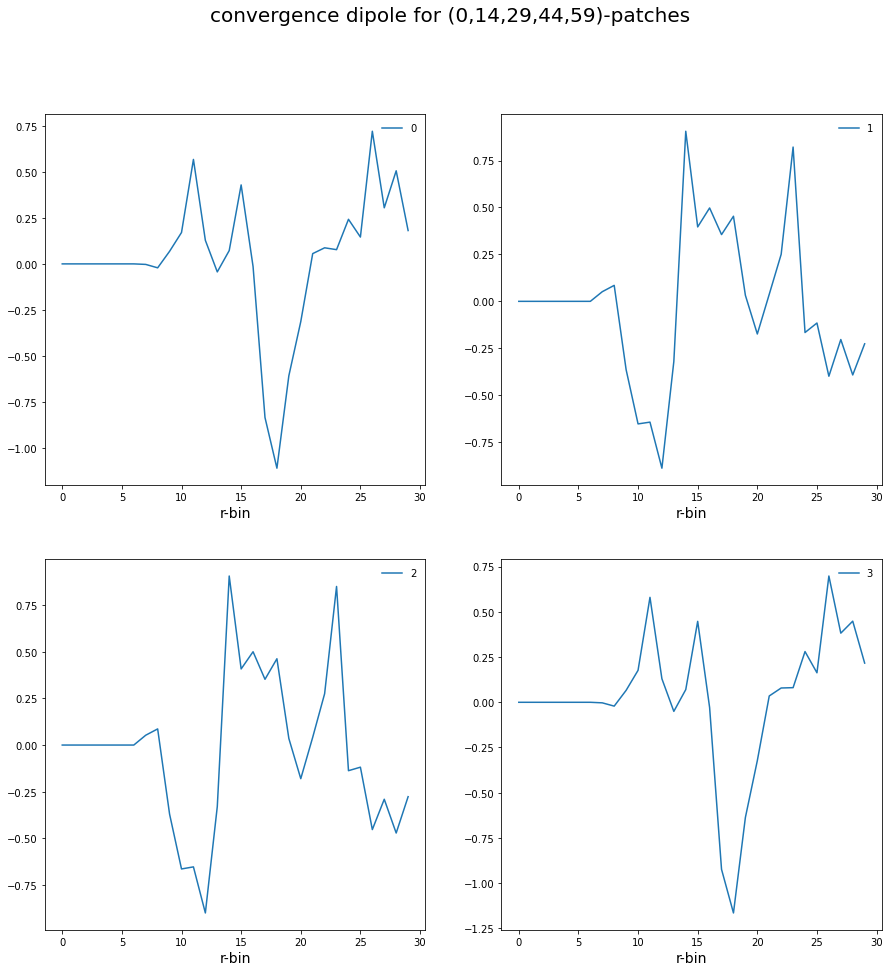

In [32]:
fig=plt.figure(figsize=(15, 15))
plt.suptitle("convergence dipole for (0,14,29,44,59)-patches",fontsize=20)
plt.tight_layout()
for nn in range(len(kkk_multipoles)):  
    ax=fig.add_subplot(2,2,nn+1)
    plt.plot(np.diagonal(kkk_multipoles[nn]/np.max(kkk_multipoles[nn])),label="%d"%(nn))
    plt.legend(frameon=False,ncol=2)
    plt.xlabel("r-bin",fontsize=14)
plt.savefig("KKK_dipole_rmax4_0-14-29-44-59_diagonal.jpg",dpi=150)
plt.show()